<a href="https://colab.research.google.com/github/srujannayak32/MLLAB189/blob/main/MLLAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("/content/drive/MyDrive/MLLAB DATASETS/titanic_train.csv")
df.head()
print("Shape:", df.shape)
print("Data Types: ")
print(df.dtypes)

Shape: (891, 12)
Data Types: 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


FILTER METHODS


In [9]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=np.number)

# Find constant features in numerical columns
constant_features = [
    features for features in numerical_df.columns if numerical_df[features].std() == 0
]
print(f"Number of constant features: {len(constant_features)}")
print(f"Constant features: {constant_features}")

Number of constant features: 0
Constant features: []


In [10]:
quasi_constant_features = []
for feature in df.columns:
    predominant = (df[feature].value_counts() / len(df)).sort_values(ascending=False).values[0]
    if predominant > 0.9:
        quasi_constant_features.append(feature)

print(f"Number of Quasi Constant Features: {len(quasi_constant_features)}")

Number of Quasi Constant Features: 0


In [11]:
duplicated_feat = []

for i in range(len(df.columns)):
    col_1 = df.columns[i]
    for col_2 in df.columns[i + 1:]:
        if df[col_1].equals(df[col_2]):
            duplicated_feat.append(col_2)

print("Duplicated features:", duplicated_feat)

Duplicated features: []


STASTICAL METHODS


<Axes: >

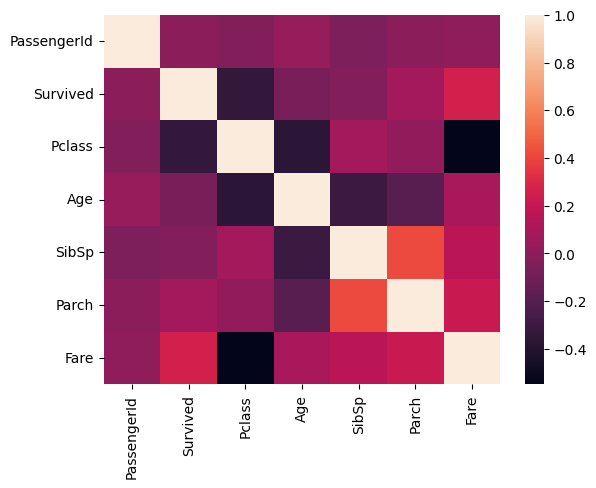

In [13]:
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numerical columns
corrmat = numerical_df.corr()

# Generate the heatmap
sns.heatmap(corrmat)

In [15]:
def correlation(dataset, threshold):
    col_corr = set()
    # Select only numerical columns for correlation calculation
    numerical_dataset = dataset.select_dtypes(include=np.number)
    matrix = numerical_dataset.corr()
    for i in range(len(matrix.columns)):
        for j in range(i):
            if abs(matrix.iloc[i, j]) > threshold:
                colname = matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.9)
correlated = set(corr_features)
correlated

set()

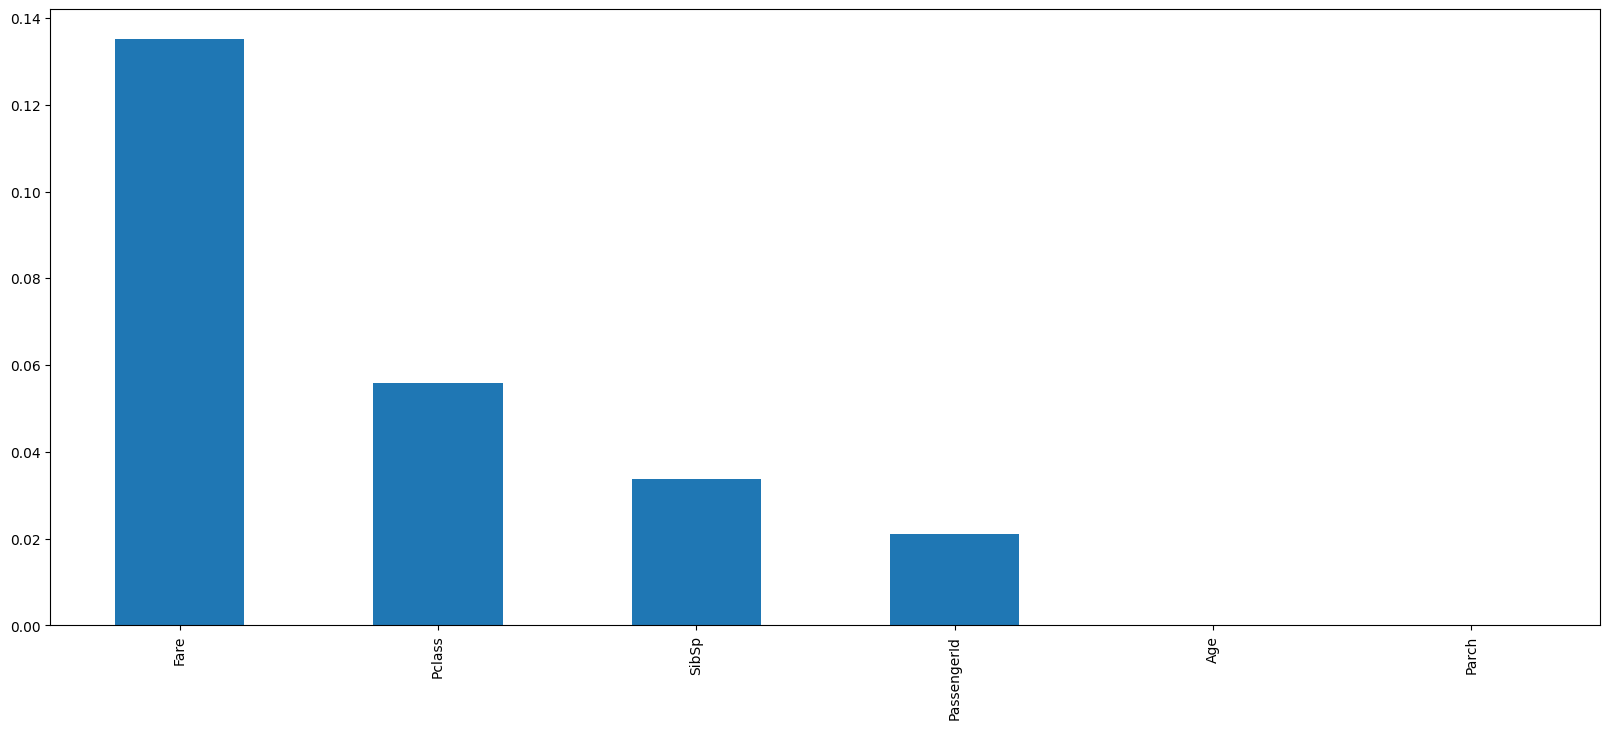

In [17]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop(labels='Survived', axis=1)
y = df['Survived']

# Select only numerical columns from X
X_numerical = X.select_dtypes(include=np.number)

# Fill missing values with 0 (only for numerical columns)
mi = mutual_info_classif(X_numerical.fillna(0), y)
mi = pd.Series(mi)
mi.index = X_numerical.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

In [18]:
selected_features = mi[mi > 0.0001].index.tolist()
print(f"Number of Selected Features: {len(selected_features)}")
print(f"Selected Features: {(selected_features)}")
X = X[selected_features]
print(X)

Number of Selected Features: 4
Selected Features: ['PassengerId', 'Pclass', 'SibSp', 'Fare']
     PassengerId  Pclass  SibSp     Fare
0              1       3      1   7.2500
1              2       1      1  71.2833
2              3       3      0   7.9250
3              4       1      1  53.1000
4              5       3      0   8.0500
..           ...     ...    ...      ...
886          887       2      0  13.0000
887          888       1      0  30.0000
888          889       3      1  23.4500
889          890       1      0  30.0000
890          891       3      0   7.7500

[891 rows x 4 columns]


Statistical Methods - Chi2 test

In [19]:
from sklearn.feature_selection import chi2
f_score = chi2(X, y)
f_score
p_values = pd.Series(f_score[1])
p_values.index = X.columns
p_values.sort_values(ascending = True)

,0
Fare,0.000000e+00
Pclass,2.753786e-08
PassengerId,6.873667e-02
SibSp,1.080942e-01


In [20]:
p_values[p_values < 0.05].sort_values(ascending=True)

,0
Fare,0.000000e+00
Pclass,2.753786e-08


Statistical Methods - ANOVA

F-scores: [2.22848123e-02 1.15031272e+02 1.11057220e+00 6.30307642e+01]
p-values: [8.81365777e-01 2.53704739e-25 2.92243929e-01 6.12018934e-15]


,0
Pclass,2.537047e-25
Fare,6.120189e-15
SibSp,2.922439e-01
PassengerId,8.813658e-01


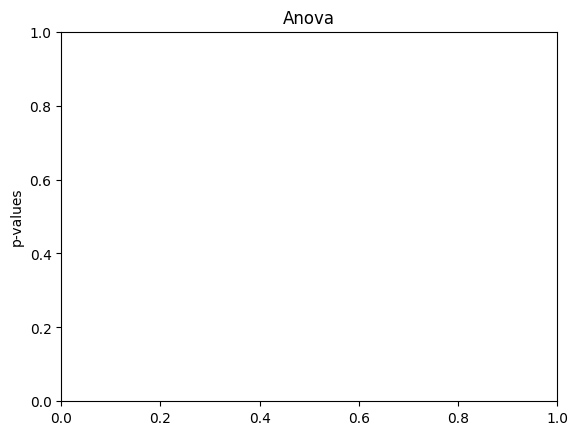

In [21]:
from sklearn.feature_selection import f_classif
f_score, p_value = f_classif(X, y)
print("F-scores:", f_score)
print("p-values:", p_value)
p_values = pd.Series(p_value)
p_values.index = X.columns
# p_values.sort_values(ascending=True).plot.bar(figsize=(20, 6), rot=45)
plt.ylabel("p-values")
plt.title("Anova")
p_values.sort_values(ascending=True)

In [22]:
p_values[p_values > 0.05]

,0
PassengerId,0.881366
SibSp,0.292244


Statistical Methods - MSE

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

roc_values = []
for feature in X.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X[feature].fillna(0).to_frame(), y)
    y_scored = clf.predict_proba(X[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y, y_scored[:, 1]))

roc_values = pd.Series(roc_values)
roc_values.index = X.columns
roc_values.sort_values(ascending=False)
roc_values[roc_values > 0.5]

,0
PassengerId,1.000000
Pclass,0.681417
SibSp,0.596539
Fare,0.896731


Wrapper Methods

In [25]:
#forward selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import  RandomForestClassifier
print(X.columns)
sfs1 = SFS(
    RandomForestClassifier(n_jobs=4),
    k_features='best', # Changed from 7 to 'best'
    forward=True,
    floating=False,
    verbose=2,
    scoring='roc_auc',
    cv=3
)
sfs1 = sfs1.fit(np.array(X.fillna(0)), y)
selected_feature_names = [X.columns[i] for i in sfs1.k_feature_idx_]

# Print the best accuracy score, indices, and feature names
print('Best accuracy score: %.2f' % sfs1.k_score_)
print('Best subset (indices):', sfs1.k_feature_idx_)
print('Best subset (corresponding names):', selected_feature_names)

Index(['PassengerId', 'Pclass', 'SibSp', 'Fare'], dtype='object')


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s finished

[2025-08-22 04:08:53] Features: 1/4 -- score: 0.7212555523599528[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s finished

[2025-08-22 04:08:57] Features: 2/4 -- score: 0.7212156073243218[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s finished

[2025-08-22 04:09:00] Features: 3/4 -- score: 0.7012830345444668

Best accuracy score: 0.72
Best subset (indices): (3,)
Best subset (corresponding names): ['Fare']


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished

[2025-08-22 04:09:01] Features: 4/4 -- score: 0.6930943022401176

In [27]:
#backward selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import  RandomForestClassifier
print(X.columns)
sfs2 = SFS(
    RandomForestClassifier(n_jobs=4),
    k_features='best', # Changed from 7 to 'best'
    forward=False,
    floating=False,
    verbose=3,
    scoring='accuracy',
    cv=3
)
sfs2 = sfs2.fit(np.array(X.fillna(0)), y)
selected_feature_names = [X.columns[i] for i in sfs2.k_feature_idx_]

# Print the best accuracy score, indices, and feature names
print('Best accuracy score: %.2f' % sfs2.k_score_)
print('Best subset (indices):', sfs2.k_feature_idx_)
print('Best subset (corresponding names):', selected_feature_names)

Index(['PassengerId', 'Pclass', 'SibSp', 'Fare'], dtype='object')


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.5s finished

[2025-08-22 04:09:31] Features: 3/1 -- score: 0.6902356902356903[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s finished

[2025-08-22 04:09:34] Features: 2/1 -- score: 0.6902356902356903

Best accuracy score: 0.69
Best subset (indices): (1, 2, 3)
Best subset (corresponding names): ['Pclass', 'SibSp', 'Fare']


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s finished

[2025-08-22 04:09:36] Features: 1/1 -- score: 0.67003367003367